###   Importing libraries

In [21]:
from csv import DictReader
from csv import DictWriter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
import spacy
import pandas as pd

### Importing Dataset

In [22]:
# Load data
train_bodies = pd.read_csv('train_bodies.csv')
train_stances = pd.read_csv('train_stances.csv')

In [24]:
train_bodies_copy = train_bodies.copy()
train_bodies_copy.head(5)
train_stances_copy =train_stances.copy()

###  Data Observation

In [89]:
train_bodies_copy.head(10)

,articleBody,Body ID
0,Islamabad: Asian Development Bank released a r...,51
1,Islamabad: Amid rising Omicron cases in a numb...,52
2,Washington: The top US health body has issued ...,53
3,England pace bowler Stuart Broad insists he wi...,54
4,Islamabad: Tens of thousands of Pakistanis are...,55
5,"Islamabad: There are ""clear early signs"" of a ...",56
6,Washington: The top US health body has issued ...,57
7,Said Individual Tested Covid -ve': India On Re...,58
8,Washington: The top US health body has issued ...,59
9,The 68-year-old premier along with his wife Bu...,60


In [90]:
train_stances_copy.head(10)

,Headline,Body ID
0,Pakistan Accumulates Over $10 Billion In New D...,51
1,Pakistan Allows Covid Booster Jabs For People ...,52
2,US Issues 'Level One' Travel Health Notice For...,53
3,"Pakistan Man In Indian Jail Since 2006, Pandem...",54
4,"Cellphone Blocks, Work Bans: Pakistan Announce...",55
5,"""Clear Early Signs"" Of Fourth COVID-19 Wave St...",56
6,England vs Pakistan: England Name New 18-Man O...,57
7,"""Said Individual Tested Covid -ve"": India On R...",58
8,200 Sikh Pilgrims Test Positive On Return From...,59
9,"Pakistan PM Imran Khan ""Fully Recovered"" From ...",60


### Text Preprocessing 

In [23]:
#data observation
import nltk
nltk.download("stopwords") 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Justin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
ps = PorterStemmer()
for i in range(0, len(train_bodies)):
    review = re.sub('[^a-zA-Z]', ' ', train_bodies['articleBody'][i])
    review = review.lower()
    review = review.split()
    
    train_bodies_copy['articleBody'][i] = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    train_bodies_copy['articleBody'][i] = ' '.join(train_bodies_copy['articleBody'][i])
for i in range(0, len(train_stances)):
    review = re.sub('[^a-zA-Z]', ' ', train_stances['Headline'][i])
    review = review.lower()
    review = review.split()
    
    train_stances_copy['Headline'][i] = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    train_stances_copy['Headline'][i] = ' '.join(train_stances_copy['Headline'][i])

C:\Users\Justin\AppData\Local\Temp\ipykernel_19208\3329142917.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_bodies_copy['articleBody'][i] = [ps.stem(word) for word in review if not word in stopwords.words('english')]
C:\Users\Justin\AppData\Local\Temp\ipykernel_19208\3329142917.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_bodies_copy['articleBody'][i] = ' '.join(train_bodies_copy['articleBody'][i])


In [91]:
train_bodies_copy.loc[10,]

articleBody    Two Hundred Sikh pilgrims from among 800 who w...
Body ID                                                       61
Name: 10, dtype: object

In [27]:
train_stances_copy.head(10)

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
6,Accused Boston Marathon Bomber Severely Injure...,962,unrelated
7,Identity of ISIS terrorist known as 'Jihadi Jo...,2033,unrelated
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
9,British Aid Worker Confirmed Murdered By ISIS,882,unrelated


In [29]:
train_bodies_copy.head(10)

,Body ID,articleBody
0,0,small meteorit crash wood area nicaragua capit...
1,4,last week hint come ebola fear spread across a...
2,5,newser wonder long quarter pounder chees last ...
3,6,post photo gun tote child onlin isi support an...
4,7,least suspect boko haram insurg kill clash sol...
5,8,much fake stuff internet given week grown tire...
6,9,cnn meteorit crash managua nicaragua late satu...
7,10,move netflix hulu word amazon look launch ad s...
8,11,seen tradit depict god cloud dwell figur flow ...
9,13,soldier shot canada nation war memori wit say ...


### Step 4 

In [92]:
#“Agrees” if
#      i) all named-entities in the headline are present in the body text
#      ii) for each noun, verb, adjective/adverb category of the headline, either the same token occurs in the body 
#             or its synonym word occurs in the body text
#      iii) there is preservation of negation (if negation is present in headline, it should be present in body text,  if headline has no negation, then body text should not contain any negation as well)

In [31]:
from nltk.corpus import brown
from gensim.models import Word2Vec
b = Word2Vec(brown.sents())


In [32]:
sim_list = []
for i in b.wv.most_similar("glass", topn=5):
    sim_list.append(i[0])
print(sim_list)
# print(train_bodies_copy['articleBody'].to_list())

['sheet', 'canvas', 'dirt', 'chill', 'blade']


In [33]:
print(brown.sents())

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]


In [34]:
import spacy
from spacy import displacy
import spacy
from negspacy.negation import Negex
nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("negex", config={"ent_types":[]})

#doc = nlp(text)
#displacy.render(doc, style = "dep")
def check_pos_tag(var_1):
    list_1 = []
    doc = nlp(var_1)
    for token in doc:
        if token.head.pos_ in ['VERB','NOUN','ADJ','ADV']:
            list_1.append(token.text)
    return list_1
    
def named_entity(var_2):
    list_2 = []
    doc = nlp(var_2)
    for ent in doc.ents:
        list_2.append(ent.text)
    return list_2
        
# First take each headings headings and convert that into pos tag in this format (Body ID, Pos of tag)
corpus = []
temp = 0

final_df = []

News_corpus =[ i.split() for i in train_bodies_copy['articleBody']]
b = Word2Vec(News_corpus)
# b.wv.most_similar("glass", topn=5) 
for i in range(0, len(train_stances_copy)):
    temp_bodyID = train_stances_copy['Body ID'][i]
    for j in range (0, len(train_bodies_copy)):
        if temp_bodyID == train_bodies_copy['Body ID'][j]:
            temp = j
            break
    count_name_tag = 0
    count_pos_tag = 0
    name_tag_body_list = []
    pos_tag_body_list = []
    name_tag_body_list = named_entity(train_bodies_copy['articleBody'][temp])
    pos_tag_body_list = check_pos_tag(train_bodies_copy['articleBody'][temp])
    doc = nlp(train_stances_copy['Headline'][i])
    doc_1 = nlp(train_bodies_copy['articleBody'][temp])
    neg_headline_list=[]
    neg_body_list=[]
    similar_list=[]
    
    for k in check_pos_tag(train_stances_copy['Headline'][i]):
        try:
            for index, tup in b.wv.most_similar(k, topn=5):
                similar_list.append(index)
            break
        except:
            pass
        
    pos_tag_body_list = pos_tag_body_list + similar_list
    for e in doc.ents:
        neg_headline_list.append(e.text+" "+ str(e._.negex))
    for e in doc_1.ents:
        neg_body_list.append(e.text+" "+ str(e._.negex))
#     print(neg_headline_list)
#     print(neg_body_list)
#     print(neg_headline_list)
#     print(neg_body_list)
    
#     if (elem in name_tag_body_list for elem in named_entity(train_stances_copy['Headline'][i])):
#         count_name_tag =count_name_tag + 1
#     if (elem in pos_tag_body_list for elem in check_pos_tag(train_stances_copy['Headline'][i])):
#         count_pos_tag = count_pos_tag + 1
        
    for elem in check_pos_tag(train_stances_copy['Headline'][i]):
        if elem in pos_tag_body_list:
            count_pos_tag = count_pos_tag + 1
    for elem in named_entity(train_stances_copy['Headline'][i]):
        if elem in name_tag_body_list:
            count_name_tag =count_name_tag + 1
    
    
    
    if count_pos_tag==0 or count_name_tag==0:
        final_df.append('unrelated')
    else:
        if len(named_entity(train_stances_copy['Headline'][i]))!=0 and all(elem in name_tag_body_list for elem in named_entity(train_stances_copy['Headline'][i])):
            final_df.append('agree')
        elif  all(elem in pos_tag_body_list for elem in check_pos_tag(train_stances_copy['Headline'][i])) :  
            final_df.append('agree')
        elif len(neg_headline_list)!=0 and all(elem in neg_body_list for elem in neg_headline_list):
            final_df.append('agree')
        elif count_pos_tag >= 1 and count_name_tag>= 1:
            final_df.append('discuss')
        else:
            for index, tup in enumerate(neg_headline_list):
                for i,j in enumerate(neg_body_list):
                    if index == i:
                        if tup != j:
                            final_df.append('disagree')
final_dataframe = pd.DataFrame (final_df, columns = ['stances'])
final_dataframe.to_csv('Final_result.csv', index=False)

In [74]:
final_dataframe = pd.read_csv("FinalResult_CSV.csv")
NLP_Dataframe = pd.read_csv("NLP_dataset_COVID_Economics.csv")
# train_stances.Stance.str.count("unrelated").sum()
# dataframe1.stances.str.count("unrelated").sum()

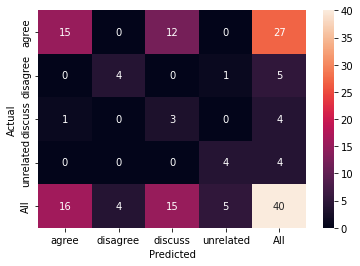

In [75]:
data = {'y_actual':    NLP_Dataframe["Stance"],
        'y_predicted': final_dataframe["Stances"]
        }
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'], margins=True)

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [76]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
y_actual =    NLP_Dataframe["Stance"]
y_predicted = final_dataframe["Stances"]

accuracy = accuracy_score(y_actual, y_predicted)
print(accuracy)


0.65


In [188]:
b.wv.most_similar("Apple", topn=5) 

[('gold', 0.9160498976707458),
 ('Judicial', 0.9082083702087402),
 ('Edition', 0.881341278553009),
 ('price', 0.8807346820831299),
 ('new', 0.876643717288971)]

In [12]:
import spacy 
import stanza 
import spacy_stanza
from negspacy.negation import Negex
from negspacy.termsets import termset 
nlp_model = spacy_stanza.load_pipeline('en')
nlp_model.add_pipe("negex", config={"ent_types":[]})
sample = nlp_model('There is no English language option.')
 
for e in sample.ents:
  print(e.text, e._.negex)

2022-10-29 15:59:58 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-10-29 16:00:53 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2022-10-29 16:00:53 INFO: Use device: cpu
2022-10-29 16:00:53 INFO: Loading: tokenize
2022-10-29 16:00:53 INFO: Loading: pos
2022-10-29 16:00:54 INFO: Loading: lemma
2022-10-29 16:00:54 INFO: Loading: depparse
2022-10-29 16:00:54 INFO: Loading: sentiment
2022-10-29 16:00:54 INFO: Loading: constituency
2022-10-29 16:00:55 INFO: Loading: ner
2022-10-29 16:00:55 INFO: Done loading processors!


English True


In [58]:
final_data = pd.read_csv("predictions_test.csv")

In [61]:
final_data.head(10)

,Stance
0,unrelated
1,unrelated
2,unrelated
3,unrelated
4,unrelated
5,unrelated
6,unrelated
7,unrelated
8,unrelated
9,unrelated


In [62]:
test_df = pd.read_csv("test_stances_unlabeled.csv")
test_df['stances'] = final_data

In [63]:
test_df.head(10)

,Headline,Body ID,stances
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated
5,Next-generation Apple iPhones' features leaked,2353,unrelated
6,Saudi national airline may introduce gender se...,192,unrelated
7,'Zombie Cat' Claws Way Out Of Grave And Into O...,2482,unrelated
8,"ISIS might be harvesting organs, Iraq tells UN",250,unrelated
9,Woman has surgery to get third breast: The thr...,85,unrelated


In [64]:
Covid_economic_data = pd.read_csv("NLP_dataset_COVID_Economic.csv", encoding = "latin-1")

In [65]:
Covid_economic_data.head(10)

,Headline,articleBody,Stance
0,"Coronavirus Live Updates: India Records 1,112 ...","India's COVID-19 caseload climbed to 4,46,46,8...",agree
1,India vaccine maker destroys 100 million doses...,Indian vaccine maker Serum Institute of India ...,agree
2,New COVID-19 vaccination round to be launched ...,A new round of COVID-19 vaccinations for peopl...,agree
3,Book a coronavirus vaccination appointment in ...,"Starting on 24 October 2022, a vaccination app...",agree
4,Influenza vaccinations and new COVID-19 vaccin...,Influenza vaccinations and a new round of COVI...,agree
5,The city's crisis management model for dealing...,The results of the third external study on the...,agree
6,COVID-19 vaccinations for 1stâ5th-graders to...,Helsinki continues to offer COVID-19 vaccines ...,agree
7,Fourth corona vaccine dose now offered to 60â...,You must book an appointment to get vaccinated...,discuss
8,COVID-19 variant-adapted booster vaccines are ...,Those aged 12 years and older can register for...,discuss
9,Self-isolation is no longer required in the ca...,"From Wednesday, 23 February, self-isolation wi...",agree


### Task 8


In [79]:
# Load data
train_bodies_copy = pd.read_csv('corona_test_bodies.csv')
train_stances_copy = pd.read_csv('corona_stance_unlabelled.csv')


In [80]:
import spacy
from spacy import displacy
import spacy
from negspacy.negation import Negex
nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("negex", config={"ent_types":[]})

#doc = nlp(text)
#displacy.render(doc, style = "dep")
def check_pos_tag(var_1):
    list_1 = []
    doc = nlp(var_1)
    for token in doc:
        if token.head.pos_ in ['VERB','NOUN','ADJ','ADV']:
            list_1.append(token.text)
    return list_1
    
def named_entity(var_2):
    list_2 = []
    doc = nlp(var_2)
    for ent in doc.ents:
        list_2.append(ent.text)
    return list_2
        
# First take each headings headings and convert that into pos tag in this format (Body ID, Pos of tag)
corpus = []
temp = 0

final_df = []

News_corpus =[ i.split() for i in train_bodies_copy['articleBody']]
b = Word2Vec(News_corpus)
# b.wv.most_similar("glass", topn=5) 
for i in range(0, len(train_stances_copy)):
    temp_bodyID = train_stances_copy['Body ID'][i]
    for j in range (0, len(train_bodies_copy)):
        if temp_bodyID == train_bodies_copy['Body ID'][j]:
            temp = j
            break
    count_name_tag = 0
    count_pos_tag = 0
    name_tag_body_list = []
    pos_tag_body_list = []
    name_tag_body_list = named_entity(train_bodies_copy['articleBody'][temp])
    pos_tag_body_list = check_pos_tag(train_bodies_copy['articleBody'][temp])
    doc = nlp(train_stances_copy['Headline'][i])
    doc_1 = nlp(train_bodies_copy['articleBody'][temp])
    neg_headline_list=[]
    neg_body_list=[]
    similar_list=[]
    
    for k in check_pos_tag(train_stances_copy['Headline'][i]):
        try:
            for index, tup in b.wv.most_similar(k, topn=5):
                similar_list.append(index)
            break
        except:
            pass
        
    pos_tag_body_list = pos_tag_body_list + similar_list
    for e in doc.ents:
        neg_headline_list.append(e.text+" "+ str(e._.negex))
    for e in doc_1.ents:
        neg_body_list.append(e.text+" "+ str(e._.negex))
#     print(neg_headline_list)
#     print(neg_body_list)
#     print(neg_headline_list)
#     print(neg_body_list)
    
#     if (elem in name_tag_body_list for elem in named_entity(train_stances_copy['Headline'][i])):
#         count_name_tag =count_name_tag + 1
#     if (elem in pos_tag_body_list for elem in check_pos_tag(train_stances_copy['Headline'][i])):
#         count_pos_tag = count_pos_tag + 1
        
    for elem in check_pos_tag(train_stances_copy['Headline'][i]):
        if elem in pos_tag_body_list:
            count_pos_tag = count_pos_tag + 1
    for elem in named_entity(train_stances_copy['Headline'][i]):
        if elem in name_tag_body_list:
            count_name_tag =count_name_tag + 1
    
    
    
    if count_pos_tag==0 or count_name_tag==0:
        final_df.append('unrelated')
    else:
        if len(named_entity(train_stances_copy['Headline'][i]))!=0 and all(elem in name_tag_body_list for elem in named_entity(train_stances_copy['Headline'][i])):
            final_df.append('agree')
        elif  all(elem in pos_tag_body_list for elem in check_pos_tag(train_stances_copy['Headline'][i])) :  
            final_df.append('agree')
        elif len(neg_headline_list)!=0 and all(elem in neg_body_list for elem in neg_headline_list):
            final_df.append('agree')
        elif count_pos_tag >= 1 and count_name_tag>= 1:
            final_df.append('discuss')
        else:
            for index, tup in enumerate(neg_headline_list):
                for i,j in enumerate(neg_body_list):
                    if index == i:
                        if tup != j:
                            final_df.append('disagree')
final_dataframe = pd.DataFrame (final_df, columns = ['stances'])
final_dataframe.to_csv('Final_result_corona.csv', index=False)

0.47619047619047616


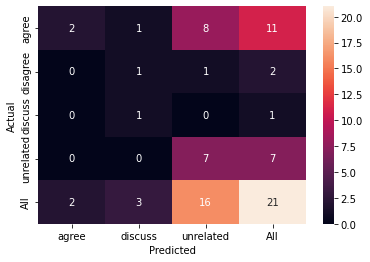

In [88]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

final_dataframe = pd.read_csv("Final_result_corona.csv")
NLP_Dataframe = pd.read_csv("FinalResult_CSV.csv")

y_actual =    NLP_Dataframe["stances"]
y_predicted = final_dataframe["stances"]

accuracy = accuracy_score(y_actual, y_predicted)
print(accuracy)

data = {'y_actual':    NLP_Dataframe["stances"],
        'y_predicted': final_dataframe["stances"]
        }
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'], margins=True)

sn.heatmap(confusion_matrix, annot=True)
plt.show()